In [1]:
# Bahdanau 注意⼒
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 定义注意⼒解码器
'''下⾯看看如何定义Bahdanau注意⼒，实现循环神经网络编码器-解码器。其实，我们只需重新定义解码器即
可。为了更⽅便地显⽰学习的注意⼒权重，以下AttentionDecoder类定义了带有注意⼒机制解码器的基本接⼝
'''

#@save
class AttentionDecoder(d2l.Decoder):
    """带有注意⼒机制解码器的基本接⼝"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    @property
    def attention_weights(self):
        raise NotImplementedError


In [3]:
'''接下来，让我们在接下来的Seq2SeqAttentionDecoder类中实现带有Bahdanau注意⼒的循环神经⽹络解码器。
⾸先，初始化解码器的状态，需要下面的输⼊：
1. 编码器在所有时间步的最终层隐状态，将作为注意力的键和值；
2. 上⼀时间步的编码器全层隐状态，将作为初始化解码器的隐状态；
3. 编码器有效长度(排除在注意⼒池中填充词元)
在每个解码时间步骤中，解码器上⼀个时间步的最终层隐状态将用作查询。因此，注意⼒输出和输⼊嵌⼊都
连结为循环神经网络解码器的输⼊
'''

class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size) # 嵌入
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs # 隐状态
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens). 编码器输出
        # hidden_state的形状为(num_layers,batch_size, 隐状态
        # num_hiddens) 
        enc_outputs, hidden_state, enc_valid_lens = state # enc_valid_lens 输出有效长度
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
            query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                        enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [4]:
'接下来，使⽤包含7个时间步的4个序列输⼊的⼩批量测试Bahdanau注意⼒解码器'
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long) # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.021, 7674.0 tokens/sec on cuda:0


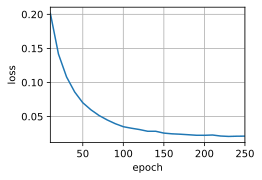

In [5]:
# 训练
''' 
与 9.7.4节类似，我们在这⾥指定超参数，实例化⼀个带有Bahdanau注意⼒的编码器和解码器，并对这个模
型进⾏机器翻译训练。由于新增的注意⼒机制，训练要⽐没有注意⼒机制的 9.7.4节慢得多
'''
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [6]:
'模型训练后，我们⽤它将⼏个英语句⼦翻译成法语并计算它们的BLEU分数'
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est riche .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [7]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

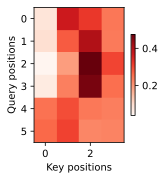

In [8]:
'''训练结束后，下面通过可视化注意力权重会发现，每个查询都会在键值对上分配不同的权重，这说明在每个
解码步中，输⼊序列的不同部分被选择性地聚集在注意力池中
'''
# 加上⼀个包含序列结束词元
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

In [ ]:
''' 小结
• 在预测词元时，如果不是所有输⼊词元都是相关的，那么具有Bahdanau注意⼒的循环神经⽹络编码
器-解码器会有选择地统计输⼊序列的不同部分。这是通过将上下⽂变量视为加性注意⼒池化的输出来
实现的
• 在循环神经⽹络编码器-解码器中，Bahdanau注意⼒将上⼀时间步的解码器隐状态视为查询，在所有时
间步的编码器隐状态同时视为键和值
'''